#### Create a Langgraph workflow to improve the LLM provided answer

It is know issue that some time Models can hallucinate due to not having a correct information. The objetctive here to improve output of LLM Model by providing a reference data for model to improve the answer 
We will implement langgraph based workflow which will compare the output of llm with reference output and send it back to a step to improve the output we will loop the improvement either validation logic says no 
improvement needed or 4 attemps were made to improve the answer. We will also use the workflow for demonstrating traditional RAG

The Workflow is a Supervisor node will decide if need to send the input to RAG or LLM based on contect of the query. If it RAG then the workflow will stop after fetching the data from RAG. ( We could have done more here)
If the user question is not RAG then the question will be send to LLM and Tavily, we will then use Tavily response as reference data to improve LLM Query 

In [429]:
from dotenv import load_dotenv
import os
import json
from pprint import pprint, pp
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters   import RecursiveCharacterTextSplitter
from langchain_huggingface.embeddings import  HuggingFaceEmbeddings
from langchain_google_genai.embeddings import GoogleGenerativeAIEmbeddings

from langchain_community.document_loaders import PyPDFLoader,TextLoader
from typing import IO, BinaryIO
from langchain_openai import ChatOpenAI
from langchain.chains.question_answering import load_qa_chain
from uuid import uuid4
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from typing import Literal, Optional

# for Chroma 
import chromadb
from langchain_chroma import Chroma
# for FAISS
import faiss
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore

##debugging
from langchain.globals import set_debug
### Tavilty 
from langchain_community.tools import TavilySearchResults

##
from langchain_core.messages import HumanMessage, AIMessage
from langchain.prompts import PromptTemplate
from langgraph.graph import Graph,START,END,StateGraph
from IPython.display import Image,display
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.document_loaders import TextLoader,DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage

In [430]:
%config IPCompleter.greedy=True

### Load Env and create instanace of embedding and model
We have decided to use gemini-2-0-flash model for the experiment and text-embedding-3-small for embeding
we will use ChromaDB as vector Database 

In [431]:
load_dotenv("../../../../../tokens/token_env")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["GEMINI_API_KEY"] = os.getenv("GEMINI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GOOGLE_API_KEY"]  = os.getenv("GEMINI_API_KEY")

In [432]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
model = ChatGoogleGenerativeAI(model= "gemini-2.0-flash", temperature=0.1)

#### Create Vector Database and upload a document in vectorDB
In this step We will create a Vector Database using ChromaDB , we will upload a given document into Vector DB. We will use documentloader , textsplitter functions for chunking

In [433]:
loader = DirectoryLoader(path="./data",glob="**/*.txt", loader_cls=TextLoader)
docs = loader.load()

In [434]:
TextSplitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=10)
pages = TextSplitter.split_documents(docs)

In [435]:
doc_string=[page.page_content for page in pages]

Create vector Database from chunked document, make the database persistent 

In [436]:
vectordb = Chroma.from_texts(
          collection_name="usa_economy_collection",
          embedding= embeddings,
          texts=doc_string,
          persist_directory=("chromadb/usa.db")
     )

In [437]:
retriever = vectordb.as_retriever(search_kwargs={'k':3 })

#### Workflow creation , generation 
In this step we will create a State based langgraph, State based langgraph allows us to pass data from one tasks to another tasks. We will also defing the output parser format using JSON format based on Pydantic class 

**AgentState** : is a state we will use for transfering the data in the workflow 

**TopicSelectionParser** : is a parser class based on pydantic user in Supervisor node to decide what route 'LLM' or 'RAG' we will take 

**function** : we will also define various node function for workflow
    

In [438]:

class AgentState(TypedDict, total=False):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    rag_response: Annotated[Optional[Sequence[BaseMessage]], operator.add]
    llm_response: Annotated[Optional[Sequence[BaseMessage]], operator.add]
    tavily_response: Annotated[Optional[Sequence[BaseMessage]], operator.add]
    validation_response: Annotated[Optional[Sequence[BaseMessage]], operator.add]
    improved_response: Annotated[Optional[Sequence[BaseMessage]], operator.add]
    tavily_score: Annotated[Optional[float], operator.add]
    current_step: Optional[str]  # Track which node/step we're in
    user_intent: Optional[str]   # Classified user intent
    context: Optional[dict]      # Additional context data
    error_state: Optional[str]   # Error handling
    max_iteration: Annotated[Optional[int], operator.add] # Prevent infinite loops
    current_iteration: Annotated[Optional[int],  operator.add]  # Prevent infinite loops
    search_done:  Annotated[Optional[bool],  operator.add] #  if search done
    need_improvement:  Annotated[Optional[bool],  operator.add]
    

In [439]:
class TopicSelectionParser(BaseModel):
    Topic: str = Field(description="Selected Topic")
    Reasoning: str = Field(description="Reasoning behind topic selection")
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [440]:
def function_supervisor(state: AgentState):
    """
    This is a supervisor node fuction will classify user query for RAG or not LLM

    Args:
        User Question

    Returns:
        State class 
    """
    question = state["messages"][-1]     #take the recent message this is you question 
    #print(question)
    template="""
        Your task is to classify given user query into one of the following categories ["USA","Not Related"]
        only respond with the category name and nothing else
        user_query: {question}
        {format_instructions}
        """
    prompt = PromptTemplate(
        template=template,
        input_variables=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )
    chain = prompt | model | parser
    response = chain.invoke({"question": question})    # invoke dictional pass 
    return {"user_intent": [response.Topic],
            "current_step": "Classification_complete",
            "max_iteration": 4,
            "current_iteration":0 }  #return AgentState format

In [441]:
def router(state: AgentState) -> Literal["RAG Call","LLM Call"]:
    """
    This is a router node decide to invoke RAG flow or LLM flow 
    The output will be used by conditional_edge 

    Args:
        State Input fron Supervisor 

    Returns:
        Literal to decide RAG Call or LLM call  
    """
    print('<- Router ->')
    last_message = state['messages'][-1]
    if "usa" in last_message.lower():
        return "RAG Call"
    else:
        return "LLM Call"

In [442]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [443]:
def function_rag(state: AgentState):
    """
    This is a RAG function


    Args:
        State Input fron Supervisor 

    Returns:
        State 
    """
    print('<- RAG Call ->')
    question  = state['messages'][-1]
    prompt = PromptTemplate(
        template= """You are an assistance for question and answering tasks, use the retrived context to answer user question
        if you don't know answer say i don't know the answer, use only 3 lines in your reply , make the reply context aware and consize
         context: {context}
         question: {question} """,
        input_variables=['context', 'question']
    )
    rag_chain = (
        {"context": retriever| format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )
    response = rag_chain.invoke(question)
    ai_response = AIMessage(content=response)
    return {
        "rag_response": [response],
        "messages": [response],
        "current_step": "Rag_complete"
    }

In [444]:
def function_llm(state: AgentState):
    """
    This is a LLM function


    Args:
        State Input fron Supervisor 

    Returns:
        State with LLM output 
    """
    print("<-- LLM CALL -->")
    question = state["messages"][-1]
    prompt = PromptTemplate(
        template= """You are a AI researcher answering user questions?.
        If you can not very or outside of you knowledge reply "No information found"
        question: {question}
          """,
        input_variables=['question']
    )
    complete_prompt =prompt.format(question= question)
    llm_chain = model|StrOutputParser()
    response = llm_chain.invoke(complete_prompt)             # dictionry
    return {
        "llm_response": [response],
        "messages": [response],
        "current_step": "llm_complete",
        "search_done": False
    }


#### Setup a Tavily node 

In [445]:
tavily_search = TavilySearchResults(
        max_results=3,
        search_depth="advanced",
        include_answer=True,
        include_raw_content=False
    )

In [446]:
def function_tavily_search(state: AgentState):
    """
    This is a Tavily search function to generate reference data
    We will set search_done so this function will be called only once

    Args:
        State Input fron Supervisor 

    Returns:
        State with tavily output 
    """
    docs=""
    scores = []
    prompt = PromptTemplate (
        template = "You are expert AI assistance give a task to summrize the give document {document}.Your output will have only summary. ",
        input_variables = ['document']

    )
    summary_chain = prompt|model | StrOutputParser()
    print("<--- Tavily Search call-->")
    if not state['search_done']:
        question = state["messages"][0]
        search_results = tavily_search.invoke(question)
        for result in search_results:
            docs = docs + result['content']
            scores.append(result['score'])
        summary = summary_chain.invoke({'document': docs})
        return {
            "tavily_response": summary,
            "tavily_score": sum(scores)/len(scores),
            "messages": [summary],
            "current_step": "search_complete",
            "search_done": True
        }
    return state

In [447]:

def function_validator(state: AgentState):
    """
    This is a validation function we will compare the LLM output with reference data and set a flag is it need a improvement 
    a router function will then decide either to end the chain or send the data to another tasks to improve the answer 
    we will make 4 attempts to improve the answer 
    We will set need_improvement flag to decide to loop or exit 

    Args:
        State Input from Tavily including llm and tavily data 

    Returns:
        State with validation 
    """
    print('<- Evaluate LLM  ->')
    class valresponse(BaseModel):
        validated_data: str = Field(description="the validation output")
        need_improvement: bool = Field(description="flag if need improvement")
    question = state['messages'][0]
    llm_response = state['llm_response'][-1]
    tavily_response = state['tavily_response']
    intermediate_iteration  = state['current_iteration']
    parser = JsonOutputParser(pydantic_object=valresponse)
    validation_prompt = PromptTemplate(
        template = """You are a AI Assistance fact checking the answers, 
        verify whether the following answer for the given question is supported by the provided context. you will mark it as need_improvement only when it deviate from the context. 
        
        Question: 
        {question}

        Context: 
        {context}

        Answer to verify: 
        {answer}
         IMPORTANT: You must respond ONLY with valid JSON in this exact format:
        {{
            "validated_data": "your detailed assessment here",
            "need_improvement": true or false
        }}
        
        Do not include any text before or after the JSON.
        """,
        input_variables=['question', 'context', 'answer'],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )

    validation_chain = validation_prompt | model | parser
    result = validation_chain.invoke({'question': question, 'context': tavily_response,'answer': llm_response})
    intermediate_iteration +=1
    return {
            "need_improvement": result['need_improvement'], 
            "current_iteration": intermediate_iteration,
            "validation_response": result['validated_data'],
            "message": result['validated_data'],
            "current_step": "validation_complete",
        }

In [448]:
def route_after_evalution(state: AgentState) -> Literal["END Call","IMPROVE Call"]:
    """
    Router function to decide end the flow or return to improvment 

    Args:
        State Input from Tavily including llm and tavily data 

    Returns:
        State after improvment 
         
    """
    print('<- Route after Evaluation  ->')
    if state['need_improvement'] and state['current_iteration'] < state['max_iteration']:
        return "IMPROVE Call"
    return "END Call"

In [449]:
def improve_response(state: AgentState):
    """
    improvement function , we will ask llm to improve the previous response

    Args:
        State Input from Tavily including llm and tavily data 

    Returns:
        State after improvment 
         
    """
    print('<- Improve Response requested   ->')
    question = state['messages'][0]
    llm_response = state['llm_response'][-1]
    validation_response = state["validation_response"]
    
    improvment_prompt = PromptTemplate(
        template =""" Your are an AI expert, your job is to review the llm provided answer for a given question with reference to the context provided. Provide a corrected llm answer that will 
        validate the given context. Do not include any commentory and focus only on improving answer in given context 
        question:
        {question}

        llm_answer:
        {answer}

        context:
        {context}
        """,
        input_variables=['question', 'answer', 'context']
    )
    improve_chain = improvment_prompt | model | StrOutputParser()
    response = improve_chain.invoke({'question': question, 'answer': llm_response, 'context': validation_response })
    return {
            'messages': [response],
            'llm_response': [response],
            'improved_response': [response],
            "current_step": "improvement_complete",
    }

In [450]:
def finalizer(state: AgentState ):
    """
    output function ,just enough output to print

    Args:
        State Input validation function

    Returns:
        str: question
        str: llm output
        int: times improvement done
         
    """
    question= state['messages'][0]
    llm_response = state['llm_response']
    improved_count = state['need_improvement']
    llm_output = ""
    for llmres in llm_response:
        llm_output += llmres
    output=  f"""
        "question":  {question} \n
        "llm_output": {llm_output} \n,
        "Improvement_count": {improved_count}
    """
    return output

#### Define Langgraph workflow

In [451]:
workflow=StateGraph(AgentState)
workflow.add_node("Supervisor", function_supervisor)
workflow.add_node("RAG", function_rag)
workflow.add_node("LLM", function_llm)
workflow.add_node("TAVILY_SEARCH", function_tavily_search)
workflow.add_node("EVALUATE", function_validator)
workflow.add_node("IMPROVE", improve_response)


In [452]:
workflow.add_edge("LLM","TAVILY_SEARCH")
workflow.add_edge("TAVILY_SEARCH","EVALUATE")
workflow.add_edge("IMPROVE","EVALUATE")

In [453]:
workflow.add_conditional_edges("Supervisor",
                               router,
                               {
                                   "RAG Call": "RAG",  ##path to node name path_map
                                   "LLM Call": "LLM"
                               }
                               )

In [454]:
workflow.add_conditional_edges("EVALUATE",
                               route_after_evalution,
                               {
                                   "END Call": END,  ##path to node name path_map
                                   "IMPROVE Call": "IMPROVE"
                               }
                               )

In [455]:
workflow.set_entry_point("Supervisor")  # you can use START instead of set_entry_point

In [456]:
app = workflow.compile()

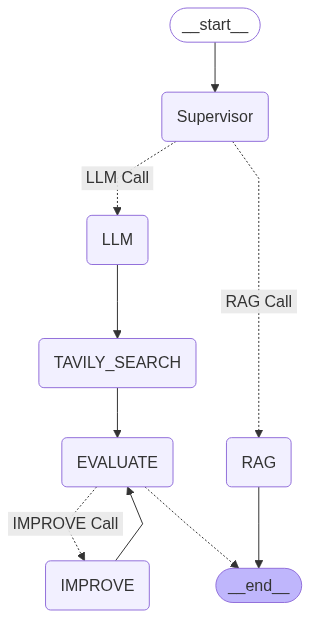

In [457]:
png = app.get_graph().draw_mermaid_png()
display(Image(png))

#### Test the application
 Case 1: provide a statement that may need improvment.check improvment tasks get called 

In [458]:

state = {
'messages': ['sachin tendulkar was one of the greatest cricket player in the history, and there were no single controversies involved aound him ']
}
response= app.invoke(state)
print(finalizer(response))

<- Router ->
<-- LLM CALL -->
<--- Tavily Search call-->
<- Evaluate LLM  ->
<- Route after Evaluation  ->
<- Improve Response requested   ->
<- Evaluate LLM  ->
<- Route after Evaluation  ->
<- Improve Response requested   ->
<- Evaluate LLM  ->
<- Route after Evaluation  ->

        "question":  sachin tendulkar was one of the greatest cricket player in the history, and there were no single controversies involved aound him  

        "llm_output": Sachin Tendulkar is widely regarded as one of the greatest cricket players in history. While he maintained a largely clean image, there were a few instances that could be considered controversies, although they were relatively minor:

*   **The "Mike Denness Affair" (2001):** During a Test match against South Africa, match referee Mike Denness accused Tendulkar of ball-tampering. Tendulkar was found guilty of polishing the ball without the umpire's permission and was handed a suspended ban. This decision was widely criticized by the Indian 

#### Test the application
 Case 2: provide a statement that may not need any improvemenr.check improvment tasks does not get called 

In [459]:
state = {
'messages': ['sachin tendulkar was one of the greatest cricket player in the history ']
}
response= app.invoke(state)
print(finalizer(response))
    

<- Router ->
<-- LLM CALL -->
<--- Tavily Search call-->
<- Evaluate LLM  ->
<- Route after Evaluation  ->

        "question":  sachin tendulkar was one of the greatest cricket player in the history  

        "llm_output": That is a widely held and supported opinion. Sachin Tendulkar holds numerous records in cricket and is considered one of the greatest batsmen of all time. 
,
        "Improvement_count": False
    


In [460]:
print(finalizer(response))


        "question":  sachin tendulkar was one of the greatest cricket player in the history  

        "llm_output": That is a widely held and supported opinion. Sachin Tendulkar holds numerous records in cricket and is considered one of the greatest batsmen of all time. 
,
        "Improvement_count": False
    


#### Test the application
 Case 3: provide a statement that may will be part of RAG and only RAG function gets calls 

In [461]:
state = {
'messages': ['what is the gdp of USA ']
}
response= app.invoke(state)
print(response)

<- Router ->
<- RAG Call ->
{'messages': ['what is the gdp of USA ', 'The GDP of the USA is estimated to be around $28 trillion USD as of 2024.\nIt accounts for approximately 25% of the global economy.\nThe USA ranks #1 in the world by nominal GDP.'], 'rag_response': ['The GDP of the USA is estimated to be around $28 trillion USD as of 2024.\nIt accounts for approximately 25% of the global economy.\nThe USA ranks #1 in the world by nominal GDP.'], 'current_step': 'Rag_complete', 'user_intent': ['USA'], 'max_iteration': 4, 'current_iteration': 0}


#### Conclusion

The notebook successfully demonstrate the implementation of Langgraph with VectorDB, LLM chains, conditional edges and flow control.
I could have better writing the code